In [1]:
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

import torch.nn as nn
from typing import Tuple, Iterable

import torch.nn.utils as utils

from functorch import vmap
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# Siamese Model

class SiameseNetwork(nn.Module):
    def __init__(self, cnn_layers: Iterable, linear_layers):
        super().__init__()
        
        # pass in a NN
        self.cnn_layers = nn.Sequential(*cnn_layers)
        self.linear_layers = nn.Sequential(*linear_layers)
        
    
    def forward(self, x_query: torch.Tensor, x_support: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward Pass:
            arg: Query Image (any image)
                 Support Image
        
        """
                
        x_query = self.cnn_layers(x_query)        
        x_support = self.cnn_layers(x_support)
        
        # similarity between query and support images. will be used for triplet loss
        similarity = vmap(F.pairwise_distance)(x_query, x_support)[:, None]        

        # logits for query image. will be used for cross entropy loss
        logits = self.linear_layers(x_query.view(x_query.size()[0], -1))
            
        return similarity, logits


In [25]:
def get_image(path):

    image = Image.open(path).convert("RGB")
    plt.imshow(image)
    plt.show()
    
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    image = transform(image)
    
    plt.imshow(image.permute(1, 2, 0))
        
    image = torch.unsqueeze(image, 0)
    
    return image


In [26]:

accident_model_path = 'saved_models/accident_with_cifar_best_model.pth'
severity_model_path = 'saved_models/severity_best_model.pth'

accident_model = torch.load(accident_model_path)
severity_model = torch.load(severity_model_path)


In [27]:
# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])

# print(params)

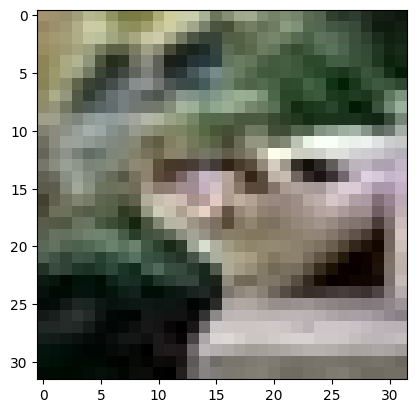


Accident : No, Yes

Probabilities :  [0.48750684 0.17141803 0.3410752 ] 
Prediction   :  0 



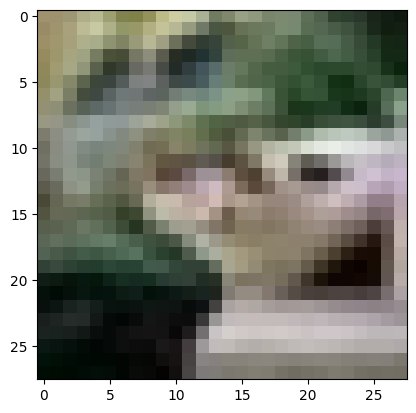

In [33]:
accident_model.eval()
severity_model.eval()

image = get_image("test_images/0987.jpg")

_, acc_logits = accident_model(image, image)
acc_logits = torch.softmax(acc_logits, dim=-1)

accident_prediction = torch.argmax(acc_logits, dim=-1).item()


print("\nAccident : No, Yes\n")
print("Probabilities : ", acc_logits.detach().numpy()[0], "\nPrediction   : ", accident_prediction, "\n")

if(accident_prediction == 1):
    _, sev_logits = severity_model(image, image)
    sev_logits = torch.softmax(sev_logits, dim=-1)

    severity_prediction = torch.argmax(sev_logits, dim=-1).item()

    print("\nSeverity : Low, Medium, High\n")
    print("Probabilities : ", sev_logits.detach().numpy()[0], "\nPrediction   : ", severity_prediction, "\n")